In [1]:
# PINNs for solving Burgers equations
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict

In [3]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, act=torch.nn.Tanh):
        super(NN, self).__init__()

        # input layer
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        # hidden layers
        for i in range(depth): 
            layers.append(('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size)))
            layers.append(('activation_%d' % i, act()))
        # output layer
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        # create neural network with layers
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [9]:
# Physics-informed Neural Network
class PINN:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # initialize model
        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        # create coordinate points (x,t)
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        # self.X.shape -> [231, 2]

        # boundary coordinate points
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # when x=-1
        # self.bc1.shape -> [11, 2]
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T # when x=1
        # self.bc2.shape -> [11, 2]
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # when t=0
        # self.ic.shape -> [21, 2]
        self.X_boundary = torch.cat([bc1, bc2, ic]) 
        # self.X_boundary -> [43, 2]

        # the u value at boundary coordinate points
        u_bc1 = torch.zeros(len(bc1))
        u_bc2 = torch.zeros(len(bc2))
        # u_bc1, u_bc2 = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) -> torch.Size([11])
        u_ic = -torch.sin(math.pi * ic[:, 0])
        # u_ic -> torch.Size([21])
        self.U_boundary = torch.cat([u_bc1, u_bc2, u_ic])
        # self.U_boundary -> torch.Size([43])
        self.U_boundary = self.U_boundary.unsqueeze(1)
        
        # training data to device
        self.X = self.X.to(device)
        self.X_boundary = self.X_boundary.to(device)
        self.U_boundary = self.U_boundary.to(device)
        self.X.requires_grad = True # X requires gradient calculation

        # set criterion
        self.criterion = torch.nn.MSELoss() # mean-squared error
        self.iter = 1
        
        # set optimizer - LBFGS and Adam for approximating u values
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=5000, 
            max_eval=5000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1e-9,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
  
    def loss_func(self):
        # zero grad both optimizers
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # part I: loss of predictions on X_boundary 
        U_pred_boundary = self.model(self.X_boundary)
        loss_boundary = self.criterion(U_pred_boundary, self.U_boundary)

        # part II, loss of predictions on X based on partial differential equations
        U = self.model(self.X)

        # calculate dU_dx, dU_dt and dU_dxx
        dU_dX = torch.autograd.grad(
            inputs=self.X, 
            # X -> (x,t)
            outputs=U, 
            grad_outputs=torch.ones_like(U), 
            # grad_outputs should be a sequence of length matching output
            retain_graph=True, 
            create_graph=True 
            # If create_graph=True, graph of the derivative will be constructed, 
            # allowing to compute higher order derivative products.  
        )[0] # return type of torch.autograd.grad: Tuple[Tensor, …]
        
        dU_dx = dU_dX[:, 0] # X -> (x,t)
        dU_dt = dU_dX[:, 1]

        dU_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=dU_dX, 
            grad_outputs=torch.ones_like(dU_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]

        # calculate equation loss
        loss_equation = self.criterion(dU_dt + U.squeeze() * dU_dx, 0.01 / math.pi * dU_dxx)

        # calculate loss: Part I + Part II
        loss = loss_equation + loss_boundary

        loss.backward() # loss backpropagation, provide gradient information for optimizer
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval() # swithc to validation mode

In [10]:
# Training
pinn = PINN()
pinn.train()
torch.save(pinn.model, 'model.pth')

100 0.166205495595932
200 0.08846645057201385
300 0.07698684930801392
400 0.06820787489414215
500 0.062219250947237015
600 0.04255557060241699
700 0.02694246917963028
800 0.01644768938422203
900 0.013305452652275562
1000 0.011223455891013145
1100 0.005833493545651436
1200 0.003211482660844922
1300 0.0021954034455120564
1400 0.0013830370735377073
1500 0.0009615392191335559
1600 0.0007465584785677493
1700 0.0005587853374890983
1800 0.0004373112751636654
1900 0.00034140603384003043
2000 0.0002896645455621183
2100 0.00025637741782702506
2200 0.00021064921747893095
2300 0.00018663136870600283
2400 0.00017059408128261566
2500 0.00015605532098561525
2600 0.00014680219464935362
2700 0.0001356438733637333
2800 0.00012564538337755948
2900 0.00011732384882634506
3000 0.00010844491771422327
3100 9.794840298127383e-05
3200 9.120454342337325e-05
3300 8.44608002807945e-05
3400 7.994158659130335e-05
3500 7.646215090062469e-05
3600 7.305132021429017e-05


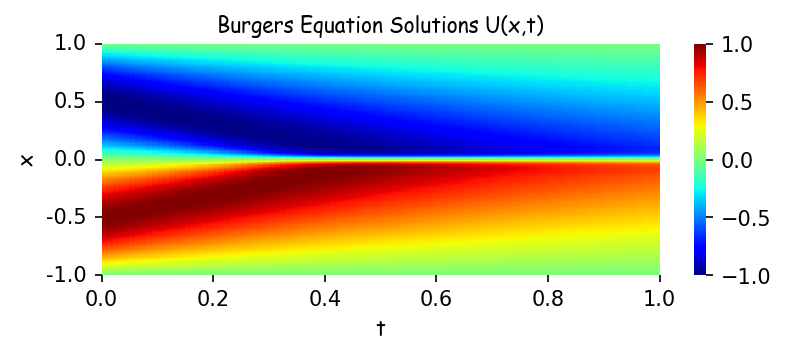

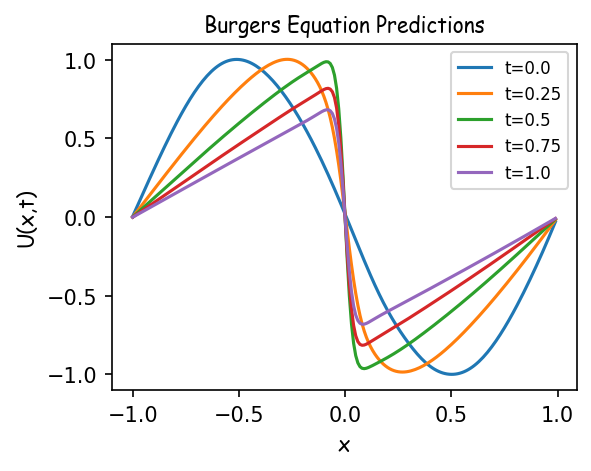

In [116]:
# load the model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_loaded = torch.load('model.pth', map_location=device)
model_loaded.eval()

# parameters
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)

# prediction
with torch.no_grad():
    U_pred = model_loaded(X).reshape(len(x), len(t)).cpu().numpy()
    # generate predictions, reshape results, move tensor to cpu, and transfer tensor to numpy array
    # U_pred -> numpy array (200, 100)

# plot
plt.figure(figsize=(6, 2), dpi=150)
ax = sns.heatmap(U_pred, vmin=-1, vmax=1, cmap='jet').invert_yaxis()
plt.title('Burgers Equation Solutions U(x,t)', fontsize = 10, fontfamily='cursive')
plt.xlabel('t', fontsize = 10, fontfamily='cursive')
plt.ylabel('x', fontsize = 10, fontfamily='cursive')

t_sns_ticks = np.linspace(0, len(t), num=6, dtype=int)
t_real_ticks = np.round(np.linspace(0.0, 1.0, num=6, dtype=float), 1)
plt.xticks(t_sns_ticks, t_real_ticks, rotation=0,)

x_sns_ticks = np.linspace(0, len(x), num=5, dtype=int)
x_real_ticks = np.round(np.linspace(-1.0, 1.0, num=5, dtype=float), 1)
plt.yticks(x_sns_ticks, x_real_ticks)

plt.show()

plt.figure(figsize=(4, 3), dpi=150)
plt.plot(x, U_pred[:, 0], '-', markersize=1, label="t=0.0")
plt.plot(x, U_pred[:, 24], '-', markersize=1, label="t=0.25")
plt.plot(x, U_pred[:, 49], '-', markersize=1, label="t=0.5")
plt.plot(x, U_pred[:, 74], '-', markersize=1, label="t=0.75")
plt.plot(x, U_pred[:, len(t)-1], '-', markersize=1, label="t=1.0")

plt.title('Burgers Equation Predictions', fontsize = 10, fontfamily='cursive')
plt.xlabel('x', fontsize = 10, fontfamily='cursive')
plt.ylabel('U(x,t)', fontsize = 10, fontfamily='cursive')
plt.legend(fontsize=8)

plt.show()